# 3. Classification

The second most popular supervised approach in ML is classification task. 

In [5]:
import os
from time import perf_counter

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd


In [29]:
plt.rcParams["figure.figsize"] = (6,6)

def timef(f,*args):
    def wrap_function(*args, **kwargs):
        start = perf_counter()
        result = f(*args, **kwargs)
        finish = perf_counter()
        print(f'Operation {f.__name__!r} executed in {(finish-start):.4f}s')
        return result
    return wrap_function(*args)

## 3.1 MNIST

Main dataset is MNIST which is the hello world of ML. Every picture is 28 x 28 so feature size is 784 and sample size is 70,000.

In [30]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [31]:
X, y = mnist.data, mnist.target
X.shape

(70000, 784)

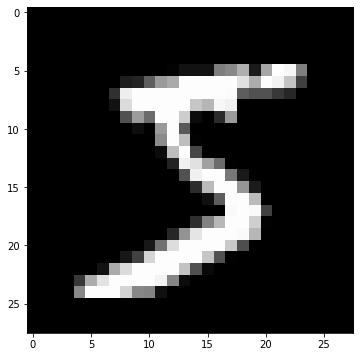

In [32]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap="gray")
plt.show()

Let's put aside a test set. The main difference between `train_test_split(data,label, stratify=y)` and `StratifiedShuffleSplit` is that first method is used for splitting data into train and test. And the second method is used in cross validation.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=10)
y_train = y_train.astype(int) # Labels are string so type assignment required
y_test = y_test.astype(int)

Let's check random samples if their labels are correct.

[8, 3, 6, 1, 1]


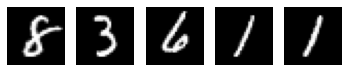

In [34]:
fig, axs = plt.subplots(1,5)
results = []
for i in range(5):
    index = np.random.randint(0,len(X_train),1)[0]
    axs[i].imshow(X_train[index].reshape(28,28), cmap="gray")
    axs[i].axis("off")
    results.append(y_train[index])
print(list(results))
plt.show()

## 3.2 Training a Binary Classifier

MNIST dataset have 10 different labels for each sample point. Instead, we start with a binary classifier.

In [35]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=10)
clf.fit(X_train, y_train_5)

SGDClassifier(random_state=10)

Let's measure test accuracy of the classifier. By the way, in the book prediction code is given like this:

```python
>>> sgd_clf.predict([some_digit])
```
Beware of the brackets for single predictions. Classifier expects an array of examples for prediction and brackets turns single digit into a list. Otherwise, an error occurs.

In [36]:
predictions = clf.predict(X_test)
accuracy = sum(predictions == y_test_5) / len(predictions)
print(f"SGDClassifier accuracy for test set : {accuracy}")

SGDClassifier accuracy for test set : 0.9341428571428572


## 3.3 Performance Measures

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
clf = SGDClassifier(random_state=10)

for train_index, val_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[val_index]
    y_test_fold = y_train_5[val_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9642149247334869
0.9365189907323084
0.9042108646737383


Now we use `cros_val_score` for evaluating classifier

In [33]:
from sklearn.model_selection import cross_val_score
sgd_clf = SGDClassifier(random_state=10)

scores = cross_val_score(clf, X_train, y_train_5, cv=5, scoring="accuracy")
scores

array([0.97008929, 0.96803571, 0.96526786, 0.96098214, 0.96258929])

We have 10 different target labels and they are approximately uniformly distributed. Therefore, predicting not 5 gives us a 90% accuracy. Let's demonstrate that with a dumb classifier.

In [34]:
# Dumb classifier
from sklearn.base import BaseEstimator

class Never5Clf(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
scores = cross_val_score(Never5Clf(), X_train, y_train_5, cv=5, scoring="accuracy")
scores

array([0.90839286, 0.90973214, 0.91071429, 0.91044643, 0.90982143])

|| Classification of Prediction Results||
|:---|:---|:---|
|**Actual**|**Prediciton**| **Term** |
|Positive | Positive | True Positive (**TP**) |
|Positive | Negative | False Negative (**FN**) |
|Negative | Negative | True Negative (**TN**) |
|Negative | Positive | False Negative (**FN**) |

- **Precision:** How precise you prediction is. Meaning, percentage of true positive predictions amongst all the positive predictions:
$$\text{Precision } = \frac{TP}{TP + FP}$$

- **Recall (Sensitivity, True Positive Rate (TPR)):** How much of the actual positives your predictions cover. Meaning, percentage of true positive predictions amongst all the actual positives.
$$\text{Recall } = \frac{TP}{TP + FN}$$

| <img src="fig/chapter3/precision_recall_CC_BY_SA_4.0.png" width=500> |
| :-- |
| **Fig**: Visualization of precision and recall (License: [CC-BY-SA-4.0](https://commons.wikimedia.org/wiki/File:Precisionrecall.svg)) |

- **F1 score:** Harmonic mean of precision and recall. A better metric when class distribution is skewed:

$$\text{F1 } = \frac{2}{\frac{1}{P} + \frac{1}{R}} = \frac{2PR}{P + R}$$

- If the threshold is too high, then you will have a few true positives (**TP**) and many false negatives (**FN**).

In [37]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

NameError: name 'sgd_clf' is not defined

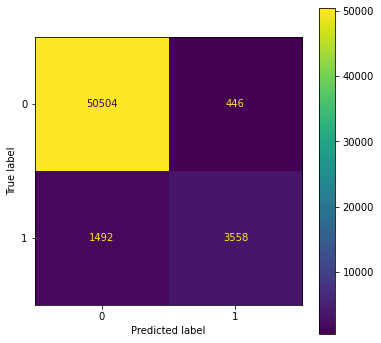

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_5, predictions)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train_5, predictions)
recall = recall_score(y_train_5, predictions)
f1 = f1_score(y_train_5, predictions)
print(f"Precision {precision}\nRecall {recall}\nF1 {f1}")

Precision 0.8886113886113887
Recall 0.7045544554455445
F1 0.7859509609012592


In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                             cv=5, method="decision_function")

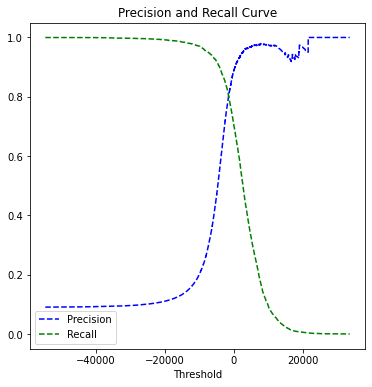

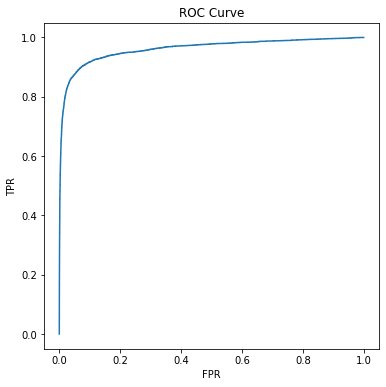

In [101]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Precision and recall Curver
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision and Recall Curve")
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [77]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.961489101137788

- Use cross validation for hyper-parameter optimization
- Use precision recall curve to choose which threshold is better for your task
- Use ROC AUC score to evaluate different models. 

## 3.4 Multiclass Classification

We can divide classifiers into groups such that ones can inherently deal with multiclass tasks and ones cannot. ML algorithms for each respectively:
- Random forests, SGD classifiers, Naive bayes 
- logistic regression and SVM cannot. 


In [111]:
from sklearn.ensemble import RandomForestClassifier
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)
train_peds = random_forest_clf.predict(X_train)
f1_score(y_train, train_peds, average="macro")

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [119]:
test_preds = random_forest_clf.predict(X_test)
f1_score(y_test, test_preds, average="micro")

0.9727857142857143

In [102]:
# Takes too LONG
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

array([7])

In [104]:
predictions = svm_clf.predict(X_train)

array([7, 3, 2, ..., 1, 0, 4])

In [107]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, predictions)

0.9894107142857143

In [108]:
test_preds = svm_clf.predict(X_test)

In [109]:
accuracy_score(y_test, test_preds)

0.9815

## 3.5 Error Analysis

Error analysis helps us to decide which class the classifier having trouble deciding to predict. For a strong classifier scoring values should be significantly different between different classes.

In [38]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()

train_preds = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
cm = confusion_matrix(y_train, train_preds)
ConfusionMatrixDisplay(cm).plot()

NameError: name 'confusion_matrix' is not defined

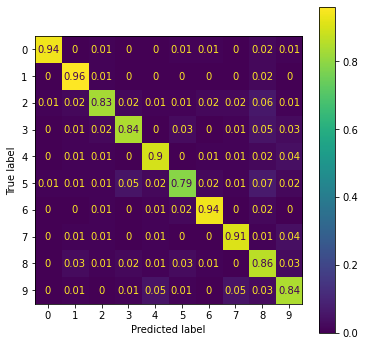

In [146]:
cm = confusion_matrix(y_train, train_preds)
def normalize_cm(matrix):
    rows,cols = matrix.shape
    result = np.zeros((rows,cols))
    for i in range(rows):
        row_sum = matrix[i,:].sum()
        result[i,:] = matrix[i,:] / row_sum
        
    return np.around(result,2)

temp = normalize_cm(cm)
ConfusionMatrixDisplay(temp).plot()
plt.show()

## 3.6 Multilabel Classification

In this iteration of classification task, a target can have more than one label. For example, a picture might have more than one object in it, therefore we need to produce a score for each possible option.

In [40]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = y_train > 7
y_train_odd = ( y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [41]:
# Training too LONG so limited
sample_size = 2000
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train[:sample_size], y_multilabel[:sample_size])

KNeighborsClassifier()

In [42]:
y_preds = knn_clf.predict(X_train[:sample_size])

In [45]:
from sklearn.metrics import f1_score
f1_score(y_multilabel[:sample_size], y_preds, average="macro")

0.9267142842756149

## 3.7 Multioutput Classification

In [49]:
noise = np.random.randint(0,100, X_train.shape)
X_train_mod = X_train + noise
noise = np.random.randint(0,100, X_test.shape)
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

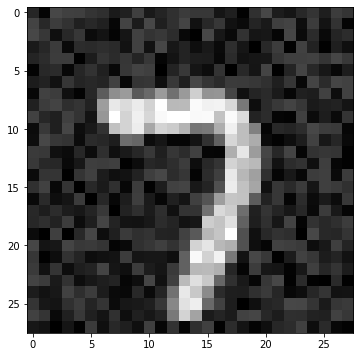

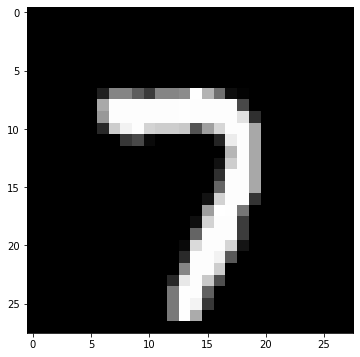

In [58]:
plt.imshow(X_train_mod[0].reshape((28,28)), cmap="gray")
plt.show()
plt.imshow(y_train_mod[0].reshape((28,28)), cmap="gray")
plt.show()

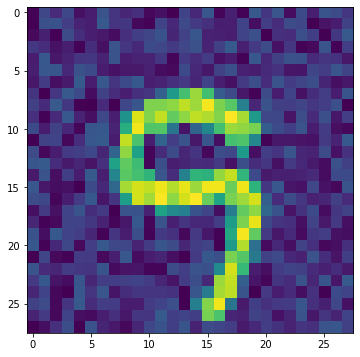

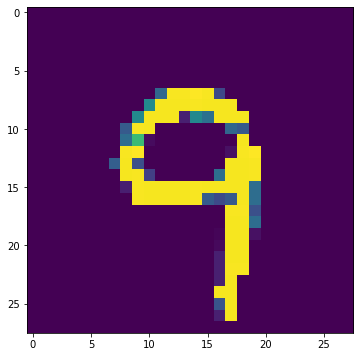

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[10]])
plt.imshow(X_test_mod[10].reshape((28,28)))
plt.show()
plt.imshow(clean_digit.reshape((28,28)))
plt.show()